Exploring Decision Trees
========================

Use a decision tree classifier to create a simplified model exploring the "Sex", "Age" and "Fare Per Person" features.

In [1]:
# set up code and dataframe with training data
import pandas as pd
import numpy as np
import statistics as st

import sklearn.metrics as ms
import sklearn.tree as tr
import sklearn.model_selection as mds

from scipy import interpolate
import matplotlib.pyplot as plt

datestamp = "20250226.185554"
df_ = pd.read_csv(f"../data/kaggle/train.clean.{datestamp}.csv")
print(df_.shape)

(891, 55)


In [2]:
#x_colnames = [ "P3orDeadTitle", "HasCabin", "AgeImputed", "FarePerPerson", "Pclass", "CabinF" ]
x_colnames = [ "P3orDeadTitle", "HasCabin", "Pclass", "TitleOrd", "Mr", "CabinOrd", 
               "FarePerPerson", "AgeImputed", "EmbarkOrd", "SexOrd" ]
y_colname = [ "Survived" ]

X = df_[ x_colnames ]
y = df_[ y_colname ].values

print(X.info())

# Assuming you have your features in X and your target variable in y
X_train, X_test, y_train, y_test = mds.train_test_split(X, y, test_size=0.2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   P3orDeadTitle  891 non-null    int64  
 1   HasCabin       891 non-null    int64  
 2   Pclass         891 non-null    int64  
 3   TitleOrd       891 non-null    float64
 4   Mr             891 non-null    int64  
 5   CabinOrd       891 non-null    float64
 6   FarePerPerson  891 non-null    float64
 7   AgeImputed     891 non-null    float64
 8   EmbarkOrd      891 non-null    float64
 9   SexOrd         891 non-null    float64
dtypes: float64(6), int64(4)
memory usage: 69.7 KB
None


In [3]:
n_folds = 6
s_scoring = "balanced_accuracy"

param_dist = {
    'max_leaf_nodes': [ 10 ],
    'max_depth': [ 6 ],
    'min_samples_split': [ 25 ],
    'min_samples_leaf': [ 15 ]
} 


# Create a decision tree classifier
clf = tr.DecisionTreeClassifier(criterion='entropy')

grid_search = mds.GridSearchCV( estimator=clf,
                                param_grid=param_dist,
                                cv=n_folds,
                                scoring=s_scoring,
                                n_jobs=-1 )

# Train the classifier
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
model       = grid_search.best_estimator_

print(best_params)
print()

{'max_depth': 6, 'max_leaf_nodes': 10, 'min_samples_leaf': 15, 'min_samples_split': 25}



In [4]:
importances = model.feature_importances_
feature_imp_df = pd.DataFrame(
    {'Feature': x_colnames, 'Gini Importance': importances} ).sort_values(
         'Gini Importance', ascending=False)
print(feature_imp_df)

         Feature  Gini Importance
0  P3orDeadTitle         0.659406
3       TitleOrd         0.180292
6  FarePerPerson         0.080634
7     AgeImputed         0.033072
8      EmbarkOrd         0.026651
5       CabinOrd         0.019946
1       HasCabin         0.000000
2         Pclass         0.000000
4             Mr         0.000000
9         SexOrd         0.000000


In [5]:
print(tr.export_text(model, show_weights=True, feature_names=x_colnames, class_names=['Dead', 'Alive']))

|--- P3orDeadTitle <= 0.50
|   |--- TitleOrd <= 2.50
|   |   |--- weights: [6.00, 13.00] class: Alive
|   |--- TitleOrd >  2.50
|   |   |--- FarePerPerson <= 38.43
|   |   |   |--- weights: [8.00, 89.00] class: Alive
|   |   |--- FarePerPerson >  38.43
|   |   |   |--- weights: [0.00, 42.00] class: Alive
|--- P3orDeadTitle >  0.50
|   |--- TitleOrd <= 1.50
|   |   |--- FarePerPerson <= 17.01
|   |   |   |--- weights: [289.00, 30.00] class: Dead
|   |   |--- FarePerPerson >  17.01
|   |   |   |--- AgeImputed <= 45.25
|   |   |   |   |--- AgeImputed <= 31.50
|   |   |   |   |   |--- weights: [20.00, 10.00] class: Dead
|   |   |   |   |--- AgeImputed >  31.50
|   |   |   |   |   |--- weights: [7.00, 12.00] class: Alive
|   |   |   |--- AgeImputed >  45.25
|   |   |   |   |--- CabinOrd <= 1.50
|   |   |   |   |   |--- weights: [16.00, 0.00] class: Dead
|   |   |   |   |--- CabinOrd >  1.50
|   |   |   |   |   |--- weights: [22.00, 8.00] class: Dead
|   |--- TitleOrd >  1.50
|   |   |--- Em

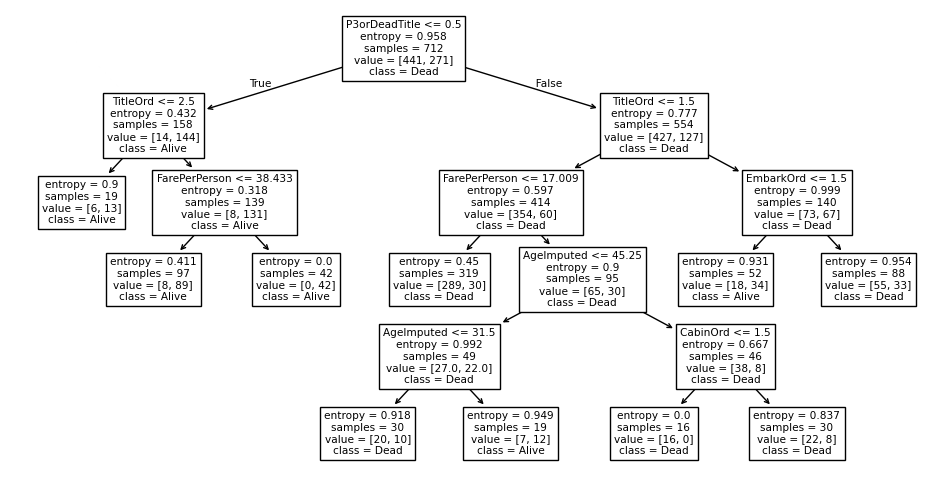

In [6]:
plt.figure(figsize=(12, 6))
tr.plot_tree(model, feature_names=x_colnames, class_names=['Dead', 'Alive'])
plt.show()

In [7]:
l_raw_scores = mds.cross_val_score(model, X_test, y_test, scoring=s_scoring, cv=n_folds)
l_scores = [ round(i, 2) for i in l_raw_scores ]

mean_score = round(st.mean(l_scores), 3)
std_score = round(st.stdev(l_scores), 3)

print(f"{n_folds}-fold {s_scoring} mean: {mean_score}, stdev: {std_score}")
print(f"  each: {l_scores}")

6-fold balanced_accuracy mean: 0.76, stdev: 0.038
  each: [np.float64(0.78), np.float64(0.76), np.float64(0.75), np.float64(0.78), np.float64(0.69), np.float64(0.8)]


In [8]:
y_train_preds_proba = model.predict_proba(X_train)

train_fpr, train_tpr, train_thresh = ms.roc_curve(y_train, y_train_preds_proba[:,1])
train_roc_auc = ms.auc(train_fpr, train_tpr)

# Calculate the geometric mean
gmeans = np.sqrt(train_tpr * (1 - train_fpr))

# Locate the index of the largest gmean
index = np.argmax(gmeans)
train_threshold = train_thresh[index]

train_tpr_intrp = interpolate.interp1d(train_thresh, train_tpr)
train_fpr_intrp = interpolate.interp1d(train_thresh, train_fpr)

print(f"Train AUC {round(train_roc_auc,3)}")
print(f"Train optimal threshold {round(train_threshold,3)} at " \
      f"tpr: {np.round(train_tpr_intrp(train_threshold),3)}, " \
      f"fpr: {np.round(train_fpr_intrp(train_threshold),3)}")

Train AUC 0.88
Train optimal threshold 0.375 at tpr: 0.823, fpr: 0.213


In [12]:
threshold = train_threshold
threshold = 0.6

In [13]:
y_test_preds_proba = model.predict_proba(X_test)
y_test_preds = (y_test_preds_proba[:,1] > threshold).astype(int)

tn, fp, fn, tp = ms.confusion_matrix(y_test, y_test_preds).ravel()
print(f"Confusion Matrix, at Threshold {threshold:.3f}")
print(f"  tn {tn:<3}  fp {fp:<3}")
print(f"  fn {fn:<3}  tp {tp:<3}")
print()

bal_acc   = round( ms.balanced_accuracy_score( y_test, y_test_preds ), 3 )
precision = round( ms.precision_score( y_test, y_test_preds ), 3 )
recall    = round( ms.recall_score( y_test, y_test_preds ), 3 )
f1        = round( ms.f1_score( y_test, y_test_preds, average='micro' ), 3 )

s_scores = f"Bal Acc: {bal_acc}, Pre: {precision}, Rec: {recall}, F1 Micro: {f1}"
print(s_scores)

Confusion Matrix, at Threshold 0.600
  tn 98   fp 10 
  fn 24   tp 47 

Bal Acc: 0.785, Pre: 0.825, Rec: 0.662, F1 Micro: 0.81


In [14]:
df_test = pd.read_csv(f"../data/kaggle/test.clean.{datestamp}.csv")

y_proba = model.predict_proba(df_test[x_colnames])
y_preds = (y_proba[:,1] > threshold).astype(int)

df_test["SurvivedProbability"] = y_proba[:,1]
df_test["Survived"] = y_preds

df_sub = df_test[ (df_test[ "Mr" ] == 0)]

df_sub[["Pclass", "Name", "Sex", "AgeImputed", "AgeRobust", "FppRobust", "SurvivedProbability", "Survived"]].head(10)

df_test[["PassengerId", "Survived"]].to_csv(f"../data/kaggle/submit.decisions.csv", index=False)